In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import json


data_path = "NPD_Data_2018_2019_V3.csv"
npd_data = pd.read_csv(data_path)

In [3]:
clean_data = npd_data.dropna()


# Tina's script for daypack analysis

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
df = pd.read_csv('NPD_Data_2018_2019_V3.csv', index_col=0)

In [5]:
df1 = df[df['Category']=='DAYPACK']\
    .reset_index()\
    .copy()
df1 = df1\
    .drop(columns='TY AUR')\
    .assign(**{'Month': pd.to_datetime(df1['Month']),
              'Units': df1['Units'].str.replace('(','-').str.replace(')','').str.replace(',','').astype(int).fillna(0)})
df1

,Month,Retailer,StoreType,State,Region,Category,Units
0,2018-04-01,AAFES,B&M,KO,OTHER,DAYPACK,0
1,2018-04-01,ACADEMY SPORTS,B&M,AL,SOUTHEAST,DAYPACK,14
2,2018-04-01,ACADEMY SPORTS,B&M,AR,SOUTH CENTRAL,DAYPACK,4
3,2018-04-01,ACADEMY SPORTS,B&M,FL,SOUTHEAST,DAYPACK,2
4,2018-04-01,ACADEMY SPORTS,B&M,GA,OTHER,DAYPACK,0
...,...,...,...,...,...,...,...
19215,2021-04-01,VON MAUR,B&M,OK,SOUTH CENTRAL,DAYPACK,0
19216,2021-04-01,VON MAUR,B&M,WI,NORTH CENTRAL,DAYPACK,0
19217,2021-04-01,VON MAUR,ECOMMERCE,IA,OTHER,DAYPACK,0
19218,2021-04-01,ZAPPOS.COM,ECOMMERCE,OTHER,OTHER,DAYPACK,256


## Units VS Time for different StoreType

In [12]:
df2.head()

,StoreType,Month,Units
0,B&M,2018-01-01,23242
1,B&M,2018-04-01,14110
2,B&M,2018-05-01,17972
3,B&M,2018-06-01,34658
4,B&M,2018-07-01,145344


Text(0.5, 1.0, 'Daypack Units for different StoreType From 2018-01 to 2021-05')

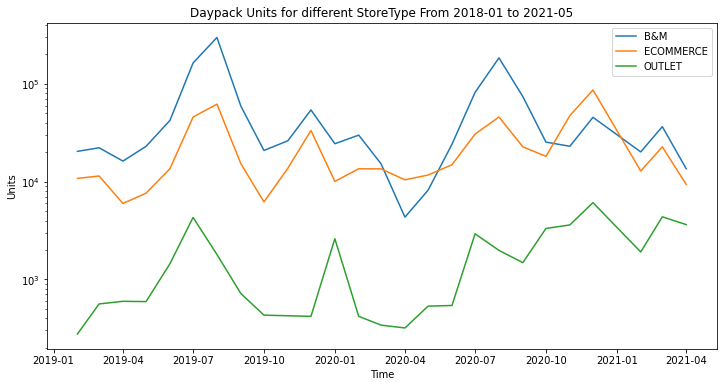

In [13]:
df2 = df1.groupby(['StoreType','Month']).agg({'Units':'sum'}).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for storetype in df2['StoreType'].unique().tolist():
    # storetype = 'ECOMMERCE'
    df3 = df2[(df2['StoreType']==storetype) & (df2['Month']>='2019-02-01')].copy().reset_index()
    ax.plot(df3['Month'], df3['Units'], label=storetype)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Units')
ax.set_title('Daypack Units for different StoreType From 2018-01 to 2021-05')

### From this plot, we can find that:
* Store type B&M and Ecommerce has yearly periodicity which is the units sales peak aroud June and July then dip around April; the outlet does not have the yearly periodicity.
* The B&M and Ecommerce have the similar trends.
* B&M has the deepest dip at 2020/April, I think there are 2 factors, one is due to seasonal influence, the other one is influneced by Covid-19. 
* At the same time, Ecommerce has the shallow dip at 2020/April. However, the dip is higher than that at the same time  2019, also higher than that of B&M at the same time, I believe the reason is more customers change their shopping behavoiur, more shopping online than come to shop.
* For Outlet sales, from 2020 May, it went up, which is very different from that at the same time 2019.

## 2019 vs 2020 daypack units comparison

In [7]:
df1['Year'] = df1['Month'].astype(str).str[:4]
df1.head()
df1['Month1'] = df1['Month'].astype(str).str[5:7]
df1['Month2'] = df1['Month'].apply(lambda x: x.strftime('%b'))
df1.head()

,Month,Retailer,StoreType,State,Region,Category,Units,Year,Month1,Month2
0,2018-04-01,AAFES,B&M,KO,OTHER,DAYPACK,0,2018,04,Apr
1,2018-04-01,ACADEMY SPORTS,B&M,AL,SOUTHEAST,DAYPACK,14,2018,04,Apr
2,2018-04-01,ACADEMY SPORTS,B&M,AR,SOUTH CENTRAL,DAYPACK,4,2018,04,Apr
3,2018-04-01,ACADEMY SPORTS,B&M,FL,SOUTHEAST,DAYPACK,2,2018,04,Apr
4,2018-04-01,ACADEMY SPORTS,B&M,GA,OTHER,DAYPACK,0,2018,04,Apr


In [25]:
df1['Month'].value_counts().sort_index()

2018-01-01    433
2018-04-01    406
2018-05-01    407
2018-06-01    421
2018-07-01    428
2018-08-01    452
2018-09-01    450
2018-10-01    434
2018-11-01    432
2018-12-01    434
2019-01-01    560
2019-02-01    437
2019-03-01    444
2019-04-01    519
2019-05-01    517
2019-06-01    561
2019-07-01    555
2019-08-01    565
2019-09-01    569
2019-10-01    551
2019-11-01    561
2019-12-01    569
2020-01-01    610
2020-02-01    542
2020-03-01    515
2020-04-01    503
2020-05-01    508
2020-06-01    539
2020-07-01    546
2020-08-01    544
2020-09-01    558
2020-10-01    603
2020-11-01    592
2020-12-01    593
2021-02-01    624
2021-03-01    620
2021-04-01    618
Name: Month, dtype: int64

In [34]:
df4_2019 = df1[(df1['Month']>='2019-01-01') & (df1['Month']<'2021-01-01')]\
            .sort_values(['Year','Month1','Month2'])\
            .groupby(['Year','Month1','Month2'], sort=False)\
                .agg({'Units': 'sum'})\
                .reset_index()
df4_2019['Month1'] = df4_2019['Month1'].astype(int).apply(lambda x: (x + 10) % 12)
df4_2019 = df4_2019.sort_values(['Year', 'Month1']).reset_index(drop=True)

labels = df4_2019[df4_2019['Year']=='2019']['Month2'].tolist()
df_19 = df4_2019[df4_2019['Year']=='2019']['Units'].tolist()
df_20 = df4_2019[df4_2019['Year']=='2020']['Units'].tolist()


,Year,Month1,Month2,Units
0,2019,0,Feb,31460
1,2019,1,Mar,34184
2,2019,2,Apr,22792
3,2019,3,May,31174
4,2019,4,Jun,57306
5,2019,5,Jul,213682
6,2019,6,Aug,362480
7,2019,7,Sep,75344
8,2019,8,Oct,27458
9,2019,9,Nov,40290


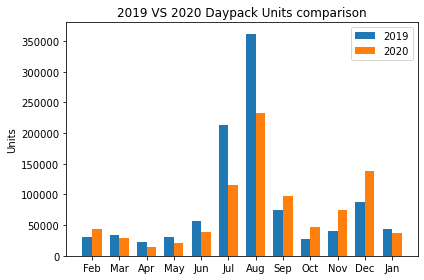

In [35]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_19, width, label='2019')
rects2 = ax.bar(x + width/2, df_20, width, label='2020')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Units')
ax.set_title('2019 VS 2020 Daypack Units comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

* There is a clear periodicity for 2019 and 2020.
* From March to Aug, total daypack units sales in 2019 is more than 2020; particularly in July and Aug, units sales in 2019 is tremendously higher than 2020. We need to investigate further for the reason.
* From Sep to Dec., total daypack units sales in 2020 is more than 2019. Maybe one of the reasons is due to covid-19, people stay at home for long time need to go outside to have a relax and enjoy natural life. We need to investigate more on that.
